# Part 2: Segmentation of musical scores

In this part, we're going to tackle slightly more complex shapes, always in binary images.

However, we're going to have to arm ourselves with some additional morphological operations to achieve this...

In the previous section, we saw:

* erosion and dilation, as well as the concept of a structuring element
* the morphological gradient
* opening (erosion and then expansion), closure (dilation and then erosion)
* top-hat (blackblack: pixels added when closed; white: pixels removed when opening)

We're going to discover three new tools:

* the labelling of related components
* area opening/closing
* morphological reconstruction

### Imports and data reading

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.measure
from ipywidgets import interact
import ipywidgets as widgets

In [15]:
img_shapes = skimage.io.imread("images/mm/binaire.png", as_gray=True).astype(bool)
img_text = skimage.io.imread("images/mm/text_binary.png", as_gray=True).astype(bool)

## 1. The notorisation and handling of related components

The notion of a related component in a binary image is very similar to the one you know for a graph: it's a group of pixels connected to each other (two pixels are connected if they are adjacent/neous - in fact it's a little more complicated because there are several adjacence relationships, but we won't go into detail here). In the binary image below.

<img src="figs/mm/composante_connexe.png" width=600>

Related components play a central role in mathematical morphology: they are often told, descriptors (size, center of gravity position, elongation, etc.). These operations are carried out very simply by combining two extremely powerful functions: [`skimage.measure.label`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) and [`skimage.measure.regionprops`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops).

In [17]:
img_lbl = skimage.measure.label(img_shapes) # get connected components labeling

[`skimage.measure.label`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) allows you to label a binary image, so that each connected component receives its own number. In image processing jargon, we call this a label map (right-hand image of the illustration above. By convention, the background of the image (therefore all the black pixels) is defined at 0 in the label card. This label card makes it possible to subsequently isolate each related component very easily (for example, if the related component n$^\circ$2 is to be insulated, it will be sufficient to write `img_lbl==2`, to obtain a binary image havint this connected component.

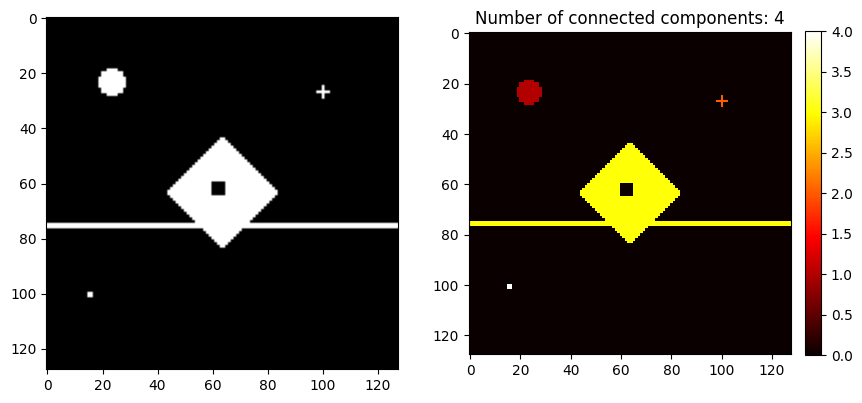

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img_shapes,cmap='gray')
plt.subplot(122)
im = plt.imshow(img_lbl,cmap='hot', interpolation="nearest")
plt.title('Number of connected components: %d'%img_lbl.max())
img_ratio = img_shapes.shape[0]/img_shapes.shape[1]
plt.colorbar(im,fraction=0.046*img_ratio,pad=0.04)
plt.show()

In general, [`skimage.measure.label`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) is used in conjunction with [`skimage.measure.regionprops`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) (`regionprops` $=$ _region properties_). The latter will calculate a whole set of descriptors (cf. the doc for the definition of these descriptors). In particular, it makes it possible to have access to the coordinates of the surrounding box (_bounding_box), i.e. the smallest rectangular region which contains in full the related component).

In [19]:
img_rp = skimage.measure.regionprops(img_lbl) # apply regionprops on label map

[`skimage.measure.regionprops`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) returns a list of type objects `RegionProperties` (one object per related component) that contain the descriptors as attributes. For example, to access the `area` (the size in pixels) of the related labeled component $1$ in the label map, we'll write `img_rp[0].area`

In [21]:
print("The siwe of the connetcted component %d is %d"%(img_rp[0].label,img_rp[0].area))

The siwe of the connetcted component 1 is 80


In [22]:
lbl_max = img_lbl.max()
@interact(lbl=widgets.IntSlider(value=1,min=1,max=lbl_max,step=1,description='label',continuous_update=False))
def print_regionprops(lbl):   
    rp_list = ['area','bbox','centroid','eccentricity','perimeter']
    img_cc = lbl*(img_lbl==lbl)
    r,c = img_cc.shape
    bbox = img_rp[lbl-1].bbox
    xmin = max(0,bbox[0])
    xmax = min(r,bbox[2])
    ymin = max(0,bbox[1])
    ymax = min(c,bbox[3])
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(img_cc,vmax=lbl_max,cmap='hot')
    plt.subplot(122)
    plt.imshow(np.pad(img_cc[xmin:xmax,ymin:ymax], 1),vmin=0,vmax=lbl_max,cmap='hot')
    plt.title('Extracting the connected components with the bounding box (+ padding)',fontsize=14)
    plt.show()
    for rp in rp_list:
        print(rp+' is : '+str(getattr(img_rp[lbl-1],rp)))

interactive(children=(IntSlider(value=1, continuous_update=False, description='label', max=4, min=1), Output()…

**Calculate and observe the image label map img_text. What can you deduce from the order with which the labeling algorithm labels the different related components of the image?**

In [ ]:
# TODO
img_txt_lbl = # get connected components labeling

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img_text,cmap='gray')
plt.subplot(122)
imt = plt.imshow(img_txt_lbl,cmap='hot', interpolation="nearest")
plt.title('Number of connected components: %d'%img_txt_lbl.max())
img_txt_ratio = img_text.shape[0]/img_text.shape[1]
plt.colorbar(imt,fraction=0.046*img_txt_ratio,pad=0.04)
plt.show()

## 2. Opening and closing by area

The calculation of morphological properties for each related component makes it possible to define the notion of filtering by attribute, i.e. retain only the related components whose attribute satisfies a given criterion. When the attribute under consideration is the area of the related component, the term “opening by area” is used and closed by area:

* For a given area threshold $T$, the opening per area keeps only those related components whose size is $> T$.

* For a given area threshold $T$, the closing per area closes the holes of the background where the size is $< T$.

In [23]:
def get_object_areas(img):
    img_lbl = skimage.measure.label(img)
    img_rp = skimage.measure.regionprops(img_lbl)
    obj_area = sorted(np.unique([rp.area for rp in img_rp]))
    return obj_area

In [24]:
from skimage.morphology import area_opening
from skimage.morphology import area_closing
MM_A = [('Area opening', area_opening), ('Area closing', area_closing)]

**Using the interactive widget below, test the area opening and area closure operations on the image img_shapesand on the image img_text. What effect is the opening per area on a related component when the threshold**

In [25]:
@interact(img_name=widgets.Dropdown(options=["img_shapes", "img_text"], description="image", index=0),
          op=widgets.RadioButtons(options=MM_A,description='operation'),
         area=widgets.IntSlider(value=1,min=1,max=1500,step=1,description='area',continuous_update=False))
def area_opening_closing(img_name, op, area):
    img = {"img_shapes": img_shapes, "img_text": img_text}[img_name]
    if op == area_opening:
        obj_area = get_object_areas(img)
        print("Sizes of connected components in the image:",obj_area)
    else:
        obj_area = get_object_areas(~img)
        print("Sizes of holes the image:",obj_area)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(img,cmap='gray')
    plt.subplot(122)
    plt.imshow(op(img,area_threshold=area),cmap='gray')
    plt.show()

interactive(children=(Dropdown(description='image', options=('img_shapes', 'img_text'), value='img_shapes'), R…

**What happens when the opening per area is carried out with an area threshold greater than the size of a component?**

... ...
Your answer here.

## 3. 3. Morphological reconstruction

Morphological reconstruction is another way of filtering the related components of an image, no longer by attribute, but by position. In practice, given an image of markers (also called seeds), the morphological reconstruction keeps in the image only the related components which contain one (or more) marker(s). For example, in the image below

<img src="figs/mm/Illustration_reconstruction_morphologique.png" width=800>

Reconstruction is an operation that is rarely used with binary images (even if you will probably have to use it for the following exercise). On the other hand, it is an important tool of grayscale morphology.

In [26]:
# create seed image
seed = np.zeros_like(img_shapes)
seed[:,seed.shape[1]//2] = True
seed = seed & img_shapes

In [27]:
img_reconstructed = skimage.morphology.reconstruction(seed, img_shapes)

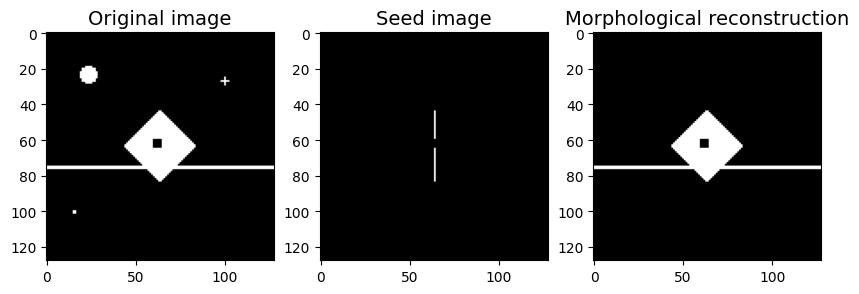

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(img_shapes,cmap='gray')
plt.title('Original image',fontsize=14)
plt.subplot(132)
plt.imshow(seed,cmap='gray')
plt.title('Seed image',fontsize=14)
plt.subplot(133)
plt.imshow(img_reconstructed,cmap='gray')
plt.title('Morphological reconstruction',fontsize=14)
plt.show()

Caution: reconstruction produces float-resaters, which can be troublesome for stringing Boolean treatments. In the next thing you may need to convert the result to `bool` with `reconstructed.astype(bool)`.

In [29]:
img_reconstructed.dtype

dtype('float64')

## 4. Extraction of shapes in musical scores

**Extract the different notes (black and round) in the image of the score below**

In [30]:
# Useful imports
from skimage.morphology import erosion
from skimage.morphology import dilation
from skimage.morphology import opening
from skimage.morphology import closing
from skimage.morphology import black_tophat
from skimage.morphology import white_tophat
from skimage.morphology import area_opening
from skimage.morphology import area_closing
from skimage.morphology import reconstruction

# some structural elements
from skimage.morphology import disk as se_disk
def se_vert_l(l):
    return np.ones((l,1))
def se_horz_l(l):
    return np.ones((1,l))

**Attention! Warning!**

For the time being, you've only seen examples of binary images, where the objects appear in white on a black background. In the example of the partition, it's the opposite, since the background is white. And by the way, the image is not binary either. It is up to you to bring you back beforehand in the case you are familiar with...

Some additional advice:

* start by filtering linear objects
* connect disconnected objects
* if you can detect some of the relevant objects (e.g. the queues of the notes), then you can use them to extract the components concerned with the reconstruction.
* filter using the size of the objects in the final steps, when you have homogeneous objects
* show your cross-media results.

Example of intermediate result (to be obtained quickly):
![](figs/mm/mm_bin_partition_exemple1.png)

Expected results: 
![](figs/mm/mm_bin_partition_resultat_attendu1.png)  
![](figs/mm/mm_bin_partition_resultat_attendu2.png)

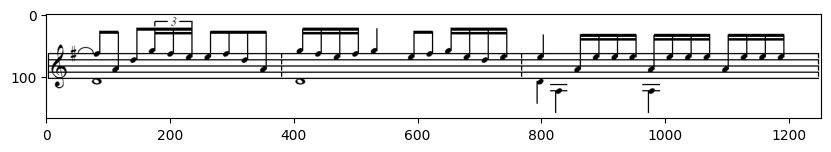

Valeur des pixels dans l'image de la partition :  [  0  51 102 153 204 255]


In [34]:
# Changing the image as ubyte
img_partition = np.uint8(255*skimage.io.imread("images/mm/partition.png", as_gray=True))
plt.figure(figsize=(10,10))
plt.imshow(img_partition,cmap='gray')
plt.show()
print("Valeur des pixels dans l'image de la partition : ",np.unique(img_partition.ravel()))

In [35]:
# TODO -- PUT ALL OF YOUR CODES HERE